This jupyter notebook is based on Python 3.7.6. 
It makes a best-fit estimation of parameters of a bidimensional model of dark energy described by a certain equation of state. It uses the MCMC method and its based on the _emcee_ Python module (see e.g. https://emcee.readthedocs.io/en/stable/tutorials/line/)

If you have any inquiries about the code or the background theory, please read the accompanying paper __"Statistical Analysis of a Bidimensional Dark Energy Parametrization"__, or email me: aldojavier@ciencias.unam.mx


Developed by:
__Aldo Javier Gamboa Castillo__

February 13th, 2021



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from scipy.optimize import minimize
from scipy import integrate, interpolate
import emcee
import corner
from IPython.display import display, Math

Constants:

In [2]:
H0 = 69 #km/s*Mpc
c = 299792.458 #km/s

In [3]:
#Load the data of supernovae and cosmic clocks
union2 = np.loadtxt("Union2-Supernovae_sample.txt", usecols = (1,2,3))
relojes = np.loadtxt("Hz_sample.txt")


z_union2 = union2[:,0]
mu_z_union2 = union2[:,1]
sigma_mu_z_union2 = union2[:,2]

#Sort the data:
inds = z_union2.argsort()
mu_z_union2s = mu_z_union2[inds]
sigma_mu_z_union2s = sigma_mu_z_union2[inds]
z_union2s = np.sort(z_union2)

#These are already ordered
z_relojes = relojes[:,0]
H_relojes = relojes[:,1]
sigma_relojes = relojes[:,2]

For a Universe filled with matter ($\Omega_m$, density parameter of matter today) and dark energy ($\Omega_X$, density parameter of dark energy today), the Friedmann equation reads:

$$ E(z)^2 \equiv \frac{H(z)^2}{H_0^2} =  \Omega_m (1 + z)^3 + \Omega_X f(z),   $$

with $\Omega_X = 1 - \Omega_m$ and

$$ f(z) =  \exp \left( 3 \int_0^z \frac{1 + w(z')}{1 + z'} \, dz' \right ), $$

and $w(z) \equiv P/\rho$ is the parametrized equation of state, with $P$ the pressure and $\rho$ the energy density.

In this work, we will use two parametrizations:

$$ w_{\Lambda\textrm{CDM}} = -1 \qquad \rightarrow \qquad  f(z) = 1 $$

$$ w(z) = \frac{ \ln w_1}{ \ln \left( \frac{w_1}{1+z} \right)} (1 + w_0) - 1  \qquad \rightarrow \qquad  f(z) = \left( \frac{ \ln w_1}{ \ln \left( \frac{w_1}{1+z} \right)} \right)^{3 (1+w_0) \ln w_1} $$

In [4]:
# Our DE model
def f(z, w0, w1):
    return  ( np.log(w1)/np.log(w1/(1+z)) )**(3*(1+w0)*np.log(w1))  #(1+z)**(3*(1+w0+w1))*np.exp(-3*w1*z)

def w(z, w0, w1):
    return (1 + w0)*np.log(w1)/np.log(w1/(1+z)) - 1

In [5]:
# LCDM
def f_L(z, w0, w1):
    return 1

def w_L(z, w0, w1):
    return -1

In [6]:
def E_inv(z, Om, w0, w1, fun):
    return 1/np.sqrt( Om*(1+z)**3 + (1-Om)*fun(z, w0, w1) )

We define the modulus distance:

$$ \mu(z) = 5 \log_{10} \left( \frac{(1+z) c}{H_0 \, 10 \textrm{pc}}  \int_0^z \frac{1}{E(z')} \, dz'   \right) $$

In [7]:
def mu(z, Om, w0, w1, fun):
    return 5*np.log10((1+z)*c*integrate.quad(E_inv, 0, z, args=(Om, w0, w1, fun))[0]/(H0*1e-5) )

# Maximum likelihood function method (Supernovae)

We write the log likelihood functions for the $\Lambda$CDM model:

$$ \mathcal{L} \propto e^{- \chi_{\textrm{SN}}^2 /2},  $$

with 

$$ \chi_{\textrm{SN}}^2 \equiv \sum_{i=1}^{N_{\textrm{Union 2}}}  \frac{ [ \mu(z_i, \Omega_m ; w_0, w_1) - \mu_{\textrm{obs}} (z_i) ]^2  }{ \sigma_{\mu, i}^2}. $$

In this way, 

$$ \ln \mathcal{L} = -\frac{1}{2} \sum_{i=1}^{N_{\textrm{Union 2}}} \left(  \frac{ [ \mu(z_i, \Omega_m ; w_0, w_1) - \mu_{\textrm{obs}} (z_i) ]^2 }{ \sigma_{\mu, i}^2}   + \ln (2 \pi \sigma_{\mu, i}^2)  \right), $$

where we have chosen a gaussian normalization.

Thus, for the $\Lambda$CDM model:

In [8]:
def log_likelihood_LCDM_sne(theta, z, mu_obs, sig_mu):
    Om = theta
    model = []
    for i in z:
        model.append(mu(i, Om, 1, 1, f_L))
    
    sigma2 = sig_mu**2 
    return -0.5 * np.sum((model - mu_obs)**2 / sigma2 + np.log(2*np.pi*sigma2))

nll_LCDM_sne = lambda *args: -log_likelihood_LCDM_sne(*args)
initial_LCDM_sne = np.array([0.3]) # We take as initial value Om= 0.3.
sol_LCDM_sne = minimize(nll_LCDM_sne, initial_LCDM_sne, args=(z_union2s, mu_z_union2s, sigma_mu_z_union2s))

In this way, the density parameter of matter $\Omega_m$ for $\Lambda$CDM model calculated with the method of maximum likelihood for the supernovae is:

In [9]:
sol_LCDM_sne.x[0]

0.31521606514722333

Now, we write the log likelihood function for our dark energy model $f$ in terms of the parameters $w_0$, $w_1$, $\Omega_m$:

In [10]:
def log_likelihood_f_sne(theta, z, mu_obs, sig_mu):
    w0, w1, Om = theta
    model = []
    for i in z:
        model.append(mu(i, Om, w0, w1, f))
    
    sigma2 = sig_mu**2 
    return -0.5 * np.sum((model - mu_obs)**2 / sigma2 + np.log(2*np.pi*sigma2))

nll_f_sne = lambda *args: -log_likelihood_f_sne(*args)
initial_f_sne = np.array([-1.1, 0.5, 0.3]) #We take these initial values for w0, w1 and Om, expecting a LCDM limit
sol_f_sne = minimize(nll_f_sne, initial_f_sne, args=(z_union2s, mu_z_union2s, sigma_mu_z_union2s))
sol_f_sne.x

C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  


array([-0.92878999,  0.50111999,  0.31807276])

In the previous array, the first number is $w_0$, the second $w_1$ and the third one is $\Omega_m$.

We create new arrays so that we can plot the best fits calculated with the maximum likelihood method:

In [11]:
model_LCDM_sne = []
for i in z_union2s:
    model_LCDM_sne.append(mu(i, sol_LCDM_sne.x[0], 1, 1, f_L))
    
model_f_sne = []
for i in z_union2s:
    model_f_sne.append(mu(i, sol_f_sne.x[2], sol_f_sne.x[0], sol_f_sne.x[1], f))

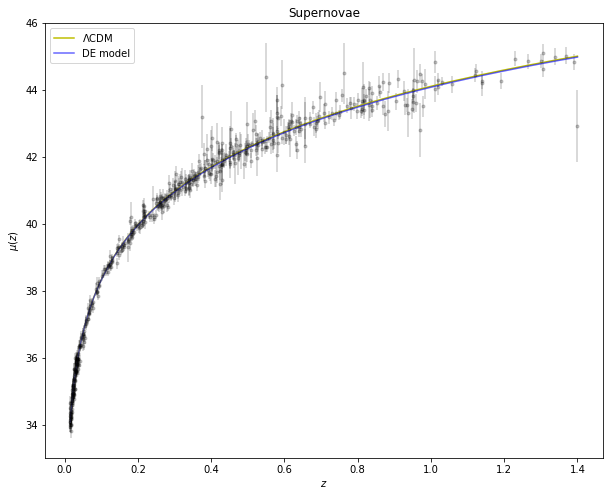

In [12]:
plt.figure(figsize=(10,8))
plt.errorbar(z_union2s, mu_z_union2s, yerr=sigma_mu_z_union2s, fmt=".k", capsize=0, alpha=0.2)
plt.plot(z_union2s, model_LCDM_sne, label=r'$\Lambda$CDM', color='y')
plt.plot(z_union2s, model_f_sne, label='DE model', color='b', alpha=0.6)

plt.title('Supernovae')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu(z)$')
plt.legend()
plt.show()

# MCMC method (Supernovae)

Now, we implement the MCMC method for the $\Lambda$CDM model and our dark energy model.

First, we define the logarithm of the prior of the $\Lambda$CDM model, and then the logarithm of the product of the prior and the likelihood of the $\Lambda$CDM model:

In [13]:
def log_prior_LCDM_sne(theta):
    Om = theta
    if 0.25 < Om < 0.35: # We propose a conservative interval, considering that O_m ~ 0.3
        return 0.0
    return -np.inf

In [14]:
def log_probability_LCDM_sne(theta, z, mu_obs, sig_mu):
    lp = log_prior_LCDM_sne(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_LCDM_sne(theta, z, mu_obs, sig_mu)

We do the same for our dark energy model:

In [15]:
def log_prior_f_sne(theta):
    w0, w1, Om = theta
    if -1.2 < w0 < -0.8 and 0.3 < w1 < 0.7 and 0.25 < Om < 0.35: # We propose these intervals based on the maximum likelihood values
        return 0.0
    return -np.inf

In [16]:
def log_probability_f_sne(theta, z, mu_obs, sig_mu):
    lp = log_prior_f_sne(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_f_sne(theta, z, mu_obs, sig_mu)

Now, we implement the MCMC method of the emcee library for the $\Lambda$CDM model for 32 walkers:

In [17]:
pos_LCDM_sne = sol_LCDM_sne.x + 1e-4 * np.random.randn(32, 1)
nwalkers_LCDM_sne, ndim_LCDM_sne = pos_LCDM_sne.shape

sampler_LCDM_sne = emcee.EnsembleSampler(nwalkers_LCDM_sne, ndim_LCDM_sne, log_probability_LCDM_sne, args=(z_union2s, mu_z_union2s, sigma_mu_z_union2s))
sampler_LCDM_sne.run_mcmc(pos_LCDM_sne, 500, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [36:23<00:00,  4.37s/it]


In [18]:
flat_samples_LCDM_sne = sampler_LCDM_sne.get_chain(discard=5, thin=1, flat=True)
print(flat_samples_LCDM_sne.shape)

(15840, 1)


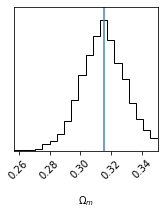

In [19]:
fig_LCDM_sne = corner.corner(flat_samples_LCDM_sne, labels=[r'$\Omega_m$'], truths=[0.315]); #The truth value is Om from Planck 2018

In [20]:
labels_LCDM_sne = [r'\Omega_m']
results_LCDM_sne = []
for i in range(ndim_LCDM_sne):
    mcmc_LCDM_sne = np.percentile(flat_samples_LCDM_sne[:, i], [16, 50, 84])
    q_LCDM_sne = np.diff(mcmc_LCDM_sne)
    txt_LCDM_sne = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt_LCDM_sne = txt_LCDM_sne.format(mcmc_LCDM_sne[1], q_LCDM_sne[0], q_LCDM_sne[1], labels_LCDM_sne[i])
    display(Math(txt_LCDM_sne))
    results_LCDM_sne.append(mcmc_LCDM_sne[1])

<IPython.core.display.Math object>

In [21]:
results_LCDM_sne

[0.31482468815801934]

We implement the MCMC method for our dark energy model with the supernovae data:

In [22]:
pos_f_sne = sol_f_sne.x + 1e-4 * np.random.randn(32, 3)
nwalkers_f_sne, ndim_f_sne = pos_f_sne.shape

sampler_f_sne = emcee.EnsembleSampler(nwalkers_f_sne, ndim_f_sne, log_probability_f_sne, args=(z_union2s, mu_z_union2s, sigma_mu_z_union2s))
sampler_f_sne.run_mcmc(pos_f_sne, 500, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [37:25<00:00,  4.49s/it]


In [23]:
flat_samples_f_sne = sampler_f_sne.get_chain(discard=5, thin=1, flat=True)
print(flat_samples_f_sne.shape)

(15840, 3)


In [25]:
labels_f_sne = [r'w_0', r'w_1', r'\Omega_m']
results_f_sne = []
for i in range(ndim_f_sne):
    mcmc_f_sne = np.percentile(flat_samples_f_sne[:, i], [16, 50, 84])
    q_f_sne = np.diff(mcmc_f_sne)
    txt_f_sne = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt_f_sne = txt_f_sne.format(mcmc_f_sne[1], q_f_sne[0], q_f_sne[1], labels_f_sne[i])
    display(Math(txt_f_sne))
    results_f_sne.append(mcmc_f_sne[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

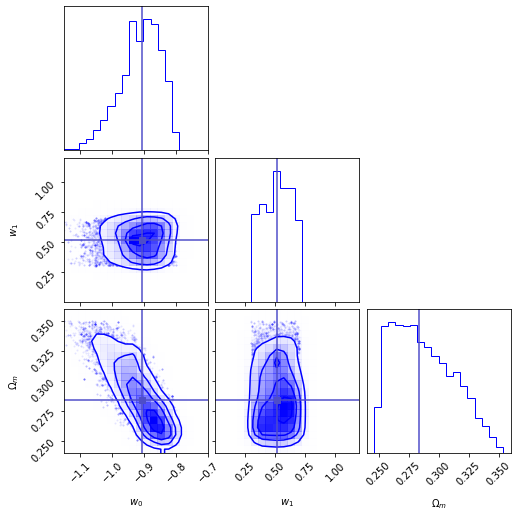

In [26]:
fig_f_sne = corner.corner(flat_samples_f_sne, range=[(-1.15,-0.7),(0,1.2),(0.24,0.36)], truth_color='#4e4dc9', smooth=0.9, color='b', labels=[r'$w_0$', r'$w_1$', r'$\Omega_m$'], truths=[results_f_sne[0], results_f_sne[1], results_f_sne[2]]);
fig_f_sne.savefig("contoursSN.png", bbox_inches='tight', dpi=500)

In [27]:
results_f_sne

[-0.9076939096244367, 0.5144073804508005, 0.28393921287973445]

# Maximum likelihood function method (H data)

In [28]:
def H(z, Om, w0, w1, fun):
    return H0*np.sqrt( Om*(1+z)**3 + (1-Om)*fun(z, w0, w1) )

In [29]:
def log_likelihood_LCDM_H(theta, z, H_obs, sig_H):
    Om = theta
    model = []
    for i in z:
        model.append(H(i, Om, 1, 1, f_L))
    
    sigma2 = sig_H**2
    return -0.5 * np.sum((model - H_obs)**2 / sigma2 + np.log(2*np.pi*sigma2))

nll_LCDM_H = lambda *args: -log_likelihood_LCDM_H(*args)
#initial = np.array([0.2]) #omega materia prior inicial    #np.array([m_true, b_true, np.log(f_true)]) 
#soln = minimize(nll_LCDM_H, initial, args=(z_relojes, H_relojes, sigma_relojes), method ='Nelder-Mead') #
#soln

The previous commented code does not work due to the form of the function H (the same code worked pretty well with the $\mu$ equation, but python seem to have problem with the function H. To overcome this problem, we will extract the data from the likelihood and interpolate it to create a new function that we will use with the MCMC method.

First we create a function of the negative likelihood just to get the minimum:

In [30]:
data = []
x = np.linspace(0,1,1000) # The variable x represents \Omega_m, and we interpolate over the interval (0,1)
for i in x:
    data.append(nll_LCDM_H(i, z_relojes, H_relojes, sigma_relojes))
    
nll_LCDM_H_interp = interpolate.interp1d(x, data, kind='quadratic') #This function will help us only to find the minimum
sol_LCDM_H = minimize(nll_LCDM_H_interp, 0.3, method='Nelder-Mead')
sol_LCDM_H.x

array([0.27667969])

Now we create the function for the likelihood:

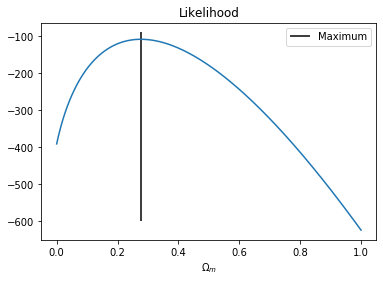

In [31]:
data2 = []
for i in x:
    data2.append(log_likelihood_LCDM_H(i, z_relojes, H_relojes, sigma_relojes))
    
ll_LCDM_H_interp = interpolate.interp1d(x, data2, kind='quadratic')

plt.plot(x, ll_LCDM_H_interp(x), '-')
plt.vlines(sol_LCDM_H.x[0], -600, -90, label='Maximum')
plt.title('Likelihood')
plt.xlabel(r'$\Omega_m$')
plt.legend()
plt.show()

Then, we define the likelihood for our DE model:

In [32]:
def log_likelihood_f_H(theta, z, H_obs, sig_H):
    w0, w1, Om = theta
    model = []
    for i in z:
        model.append(H(i, Om, w0, w1, f))
    
    sigma2 = sig_H**2 
    return -0.5 * np.sum((model - H_obs)**2 / sigma2 + np.log(2*np.pi*sigma2))

nll_f_H = lambda *args: -log_likelihood_f_H(*args)
initial_f_H = np.array([-1.1, 0.5, 0.27]) # The initial conditions are important for a consistent result
sol_f_H = minimize(nll_f_H, initial_f_H, args=(z_relojes, H_relojes, sigma_relojes))
sol_f_H.x

array([-1.10223936,  0.65652297,  0.28522813])

In the previous array, the first number is $w_0$, the second $w_1$ and the third one is $\Omega_m$.

Next we will plot the data:

In [33]:
model_LCDM_H = []
for i in z_relojes:
    model_LCDM_H.append( H(i, sol_LCDM_H.x[0], 1, 1, f_L))
    
model_f_H = []
for i in z_relojes:
    model_f_H.append(H(i, sol_f_H.x[2], sol_f_H.x[0], sol_f_H.x[1], f))

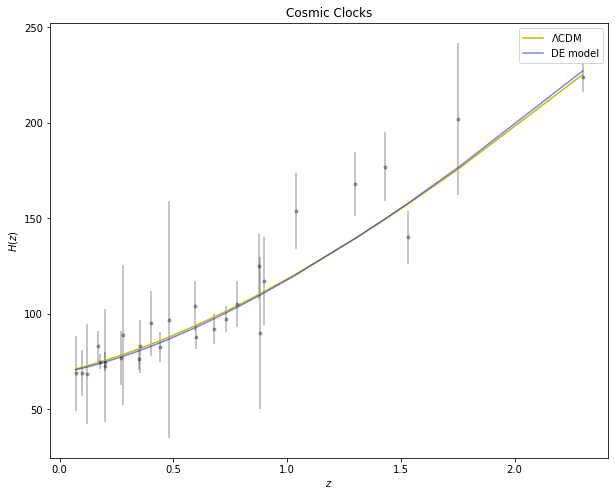

In [34]:
plt.figure(figsize=(10,8))
plt.errorbar(z_relojes, H_relojes, yerr=sigma_relojes, fmt=".k", capsize=0, alpha=0.3)
plt.plot(z_relojes, model_LCDM_H, label=r'$\Lambda$CDM', color='y')
plt.plot(z_relojes, model_f_H, label='DE model', color='b', alpha=0.5)

plt.title('Cosmic Clocks')
plt.xlabel(r'$z$')
plt.ylabel(r'$H(z)$')
plt.legend()
plt.show()

# MCMC method (H data)

We write the priors for the $\Lambda$CDM model and then for our DE model.

In [35]:
def log_prior_LCDM_H(theta):
    Om = theta
    if 0.25 < Om < 0.35: # We propose a conservative interval, considering that O_m ~ 0.3
        return 0.0
    return -np.inf

In [36]:
def log_probability_LCDM_H(theta, z, H_obs, sig_H):
    lp = log_prior_LCDM_H(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll_LCDM_H_interp(theta)

In [74]:
def log_prior_f_H(theta):
    w0, w1, Om = theta
    if -1.16 < w0 < -1.04 and 0.62 < w1 < 0.7 and 0.25 < Om < 0.35: # We prppose these intervals based on the maximum likelihood values
        return 0.0
    return -np.inf

In [38]:
def log_probability_f_H(theta, z, H_obs, sig_H):
    lp = log_prior_f_H(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_f_H(theta, z, H_obs, sig_H)

Now lets implement the MCMC method

In [39]:
pos_LCDM_H = sol_LCDM_H.x + 1e-4 * np.random.randn(32, 1)
nwalkers_LCDM_H, ndim_LCDM_H = pos_LCDM_H.shape

sampler_LCDM_H = emcee.EnsembleSampler(nwalkers_LCDM_H, ndim_LCDM_H, log_probability_LCDM_H, args=(z_relojes, H_relojes, sigma_relojes))
sampler_LCDM_H.run_mcmc(pos_LCDM_H, 1000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.21it/s]


In [40]:
flat_samples_LCDM_H = sampler_LCDM_H.get_chain(discard=5, thin=1, flat=True)
print(flat_samples_LCDM_H.shape)

(31840, 1)


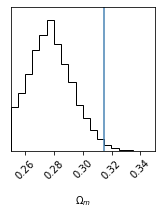

In [41]:
fig_LCDM_H = corner.corner(flat_samples_LCDM_H, labels=[r'$\Omega_m$'], truths=[0.315]);

In [42]:
labels_LCDM_H = [r'\Omega_m']
results_LCDM_H = []
for i in range(ndim_LCDM_H):
    mcmc_LCDM_H = np.percentile(flat_samples_LCDM_H[:, i], [16, 50, 84])
    q_LCDM_H = np.diff(mcmc_LCDM_H)
    txt_LCDM_H = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt_LCDM_H = txt_LCDM_H.format(mcmc_LCDM_H[1], q_LCDM_H[0], q_LCDM_H[1], labels_LCDM_H[i])
    display(Math(txt_LCDM_H))
    results_LCDM_H.append(mcmc_LCDM_H[1])

<IPython.core.display.Math object>

In [43]:
results_LCDM_H

[0.27724355820359814]

We implement the MCMC method for our dark energy model with the cosmic clocks data:

In [75]:
pos_f_H = sol_f_H.x + 1e-4 * np.random.randn(32, 3)
nwalkers_f_H , ndim_f_H  = pos_f_H.shape

sampler_f_H = emcee.EnsembleSampler(nwalkers_f_H , ndim_f_H , log_probability_f_H, args=(z_relojes, H_relojes, sigma_relojes))
sampler_f_H.run_mcmc(pos_f_H , 1000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.25it/s]


In [76]:
flat_samples_f_H = sampler_f_H.get_chain(discard=5, thin=1, flat=True)
print(flat_samples_f_H.shape)

(31840, 3)


In [77]:
labels_f_H = [r'w_0', r'w_1', r'\Omega_m']
results_f_H = []
for i in range(ndim_f_H):
    mcmc_f_H = np.percentile(flat_samples_f_H[:, i], [16, 50, 84])
    q_f_H = np.diff(mcmc_f_H)
    txt_f_H = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt_f_H = txt_f_H.format(mcmc_f_H[1], q_f_H[0], q_f_H[1], labels_f_H[i])
    display(Math(txt_f_H))
    results_f_H.append(mcmc_f_H[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

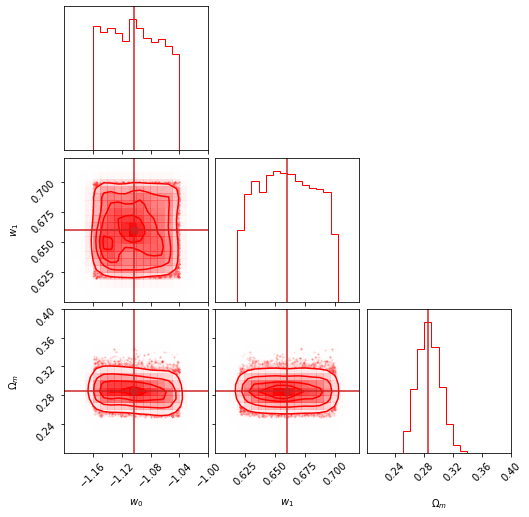

In [78]:
fig_f_H = corner.corner(flat_samples_f_H, range=[(-1.2,-1),(0.6,0.72),(0.2,0.4)], truth_color='#cf2121', smooth=1, color='r', labels=[r'$w_0$', r'$w_1$', r'$\Omega_m$'], truths=[results_f_H[0], results_f_H[1], results_f_H[2]]);
fig_f_H.savefig("contoursCC.png", bbox_inches='tight', dpi=500)

In [79]:
results_f_H

[-1.1023763044613681, 0.6593270915383362, 0.2857983594881407]

# Maximum likelihood function method (Supernovae + H data)

In [80]:
def log_likelihood_LCDM_sneH(theta, z_sne, mu_obs, sig_mu, z_H, H_obs, sig_H):
    Om = theta
    modelsne = []
    modelH = []
    for i in z_sne:
        modelsne.append(mu(i, Om, 1, 1, f_L))
    for j in z_H:
        modelH.append(H(j, Om, 1, 1, f_L))
    
    sigma2_sne = sig_mu**2
    sigma2_H = sig_H**2
    return -0.5*np.sum((modelH - H_obs)**2 / sigma2_H + np.log(2*np.pi*sigma2_H))-0.5 * np.sum((modelsne - mu_obs)**2 / sigma2_sne + np.log(2*np.pi*sigma2_sne))

nll_LCDM_sneH = lambda *args: -log_likelihood_LCDM_sneH(*args)

In [81]:
data3 = []
for i in x:
    data3.append(nll_LCDM_sneH(i, z_union2s, mu_z_union2s, sigma_mu_z_union2s, z_relojes, H_relojes, sigma_relojes))
    
nll_LCDM_sneH_interp = interpolate.interp1d(x, data3, kind='quadratic') #This function will help us only to find the minimum
sol_LCDM_sneH = minimize(nll_LCDM_sneH_interp, 0.3, method='Nelder-Mead')
sol_LCDM_sneH.x

array([0.29923828])

In [82]:
data4 = []
for i in x:
    data4.append(log_likelihood_LCDM_sneH(i, z_union2s, mu_z_union2s, sigma_mu_z_union2s, z_relojes, H_relojes, sigma_relojes))
    
ll_LCDM_sneH_interp = interpolate.interp1d(x, data4, kind='quadratic')

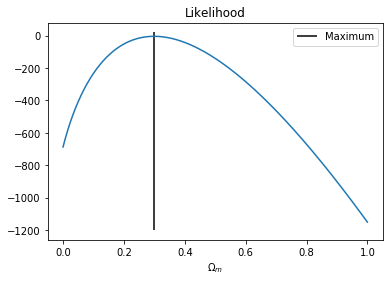

In [83]:
plt.plot(x, ll_LCDM_sneH_interp(x), '-')
plt.vlines(sol_LCDM_sneH.x[0], -1200, 20, label='Maximum')
plt.title('Likelihood')
plt.xlabel(r'$\Omega_m$')
plt.legend()
plt.show()

In [84]:
def log_likelihood_f_sneH(theta, z_sne, mu_obs, sig_mu, z_H, H_obs, sig_H):
    w0, w1, Om = theta
    modelsne = []
    modelH = []
    for i in z_sne:
        modelsne.append(mu(i, Om, w0, w1, f))
    for j in z_H:
        modelH.append(H(j, Om, w0, w1, f))
    
    sigma2_sne = sig_mu**2
    sigma2_H = sig_H**2
    return -0.5*np.sum((modelH - H_obs)**2 / sigma2_H + np.log(2*np.pi*sigma2_H))-0.5 * np.sum((modelsne - mu_obs)**2 / sigma2_sne + np.log(2*np.pi*sigma2_sne))

nll_f_sneH = lambda *args: -log_likelihood_f_sneH(*args)
initial_f_sneH = np.array([-1.1, 0.5, 0.27]) # The initial conditions are important for a consistent result
sol_f_sneH = minimize(nll_f_sneH, initial_f_sneH, args=(z_union2s, mu_z_union2s, sigma_mu_z_union2s, z_relojes, H_relojes, sigma_relojes))
sol_f_sneH.x

C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  


array([-0.91551137,  0.50377369,  0.30446136])

# MCMC method (Supernovae + H data)

In [85]:
def log_prior_LCDM_sneH(theta):
    Om = theta
    if 0.25 < Om < 0.35: # We propose a conservative interval, considering that O_m ~ 0.3
        return 0.0
    return -np.inf

In [86]:
def log_probability_LCDM_sneH(theta, z_sne, mu_obs, sig_mu, z_H, H_obs, sig_H):
    lp = log_prior_LCDM_sneH(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll_LCDM_sneH_interp(theta)

In [87]:
def log_prior_f_sneH(theta):
    w0, w1, Om = theta
    if -1.1 < w0 < -0.8 and 0.4 < w1 < 0.6 and 0.25 < Om < 0.35: # We prppose these intervals based on the maximum likelihood values
        return 0.0
    return -np.inf

In [88]:
def log_probability_f_sneH(theta, z_sne, mu_obs, sig_mu, z_H, H_obs, sig_H):
    lp = log_prior_f_sneH(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_f_sneH(theta, z_sne, mu_obs, sig_mu, z_H, H_obs, sig_H)

In [89]:
pos_LCDM_sneH = sol_LCDM_sneH.x + 1e-4 * np.random.randn(32, 1)
nwalkers_LCDM_sneH, ndim_LCDM_sneH = pos_LCDM_sneH.shape

sampler_LCDM_sneH = emcee.EnsembleSampler(nwalkers_LCDM_sneH, ndim_LCDM_sneH, log_probability_LCDM_sneH, args=(z_union2s, mu_z_union2s, sigma_mu_z_union2s, z_relojes, H_relojes, sigma_relojes))
sampler_LCDM_sneH.run_mcmc(pos_LCDM_sneH, 1000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.30it/s]


In [90]:
flat_samples_LCDM_sneH = sampler_LCDM_sneH.get_chain(discard=10, thin=1, flat=True)
print(flat_samples_LCDM_sneH.shape)

(31680, 1)


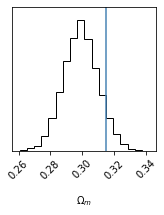

In [91]:
fig_LCDM_sneH = corner.corner(flat_samples_LCDM_sneH, labels=[r'$\Omega_m$'], truths=[0.315]);

In [92]:
labels_LCDM_sneH = [r'\Omega_m']
results_LCDM_sneH = []
for i in range(ndim_LCDM_sneH):
    mcmc_LCDM_sneH = np.percentile(flat_samples_LCDM_sneH[:, i], [16, 50, 84])
    q_LCDM_sneH = np.diff(mcmc_LCDM_sneH)
    txt_LCDM_sneH = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt_LCDM_sneH = txt_LCDM_sneH.format(mcmc_LCDM_sneH[1], q_LCDM_sneH[0], q_LCDM_sneH[1], labels_LCDM_sneH[i])
    display(Math(txt_LCDM_sneH))
    results_LCDM_sneH.append(mcmc_LCDM_sneH[1])

<IPython.core.display.Math object>

In [93]:
results_LCDM_sneH

[0.2989259007616446]

In [94]:
pos_f_sneH = sol_f_sneH.x + 1e-4 * np.random.randn(32, 3)
nwalkers_f_sneH , ndim_f_sneH  = pos_f_sneH.shape

sampler_f_sneH = emcee.EnsembleSampler(nwalkers_f_sneH , ndim_f_sneH , log_probability_f_sneH, args=(z_union2s, mu_z_union2s, sigma_mu_z_union2s, z_relojes, H_relojes, sigma_relojes))
sampler_f_sneH.run_mcmc(pos_f_sneH , 500, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [41:10<00:00,  4.94s/it]


In [95]:
flat_samples_f_sneH = sampler_f_sneH.get_chain(discard=5, thin=1, flat=True)
print(flat_samples_f_sneH.shape)

(15840, 3)


In [97]:
labels_f_sneH = [r'w_0', r'w_1', r'\Omega_m']
results_f_sneH = []
for i in range(ndim_f_sneH):
    mcmc_f_sneH = np.percentile(flat_samples_f_sneH[:, i], [16, 50, 84])
    q_f_sneH = np.diff(mcmc_f_sneH)
    txt_f_sneH = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt_f_sneH = txt_f_sneH.format(mcmc_f_sneH[1], q_f_sneH[0], q_f_sneH[1], labels_f_sneH[i])
    display(Math(txt_f_sneH))
    results_f_sneH.append(mcmc_f_sneH[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

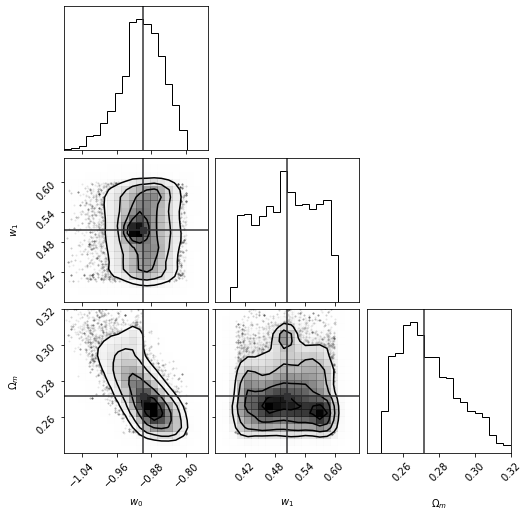

In [98]:
fig_f_sneH = corner.corner(flat_samples_f_sneH, range=[(-1.08,-0.75),(0.36,0.65),(0.24,0.32)], truth_color='#313133', smooth=0.9, labels=[r'$w_0$', r'$w_1$', r'$\Omega_m$'], truths=[results_f_sneH[0], results_f_sneH[1], results_f_sneH[2]]);

fig_f_sneH.savefig("contoursSNCC.png", bbox_inches='tight', dpi=500)

# Final plots

Lets make our final plots.

We start with the plots for the modulus distance with the parameters obtained with the MCMC methods.

In [99]:
z0 = np.linspace(0.015,1.4,1000)

model_LCDM_planck = []
for i in z0:
    model_LCDM_planck.append(mu(i, 0.315, 1, 1, f_L))
    
model_f_sne_MCMC = []
for i in z0:
    model_f_sne_MCMC.append(mu(i, results_f_sne[2], results_f_sne[0], results_f_sne[1], f))
    
model_f_H_MCMC = []
for i in z0:
    model_f_H_MCMC.append(mu(i, results_f_H[2], results_f_H[0], results_f_H[1], f))
    
model_f_sneH_MCMC = []
for i in z0:
    model_f_sneH_MCMC.append(mu(i, results_f_sneH[2], results_f_sneH[0], results_f_sneH[1], f))

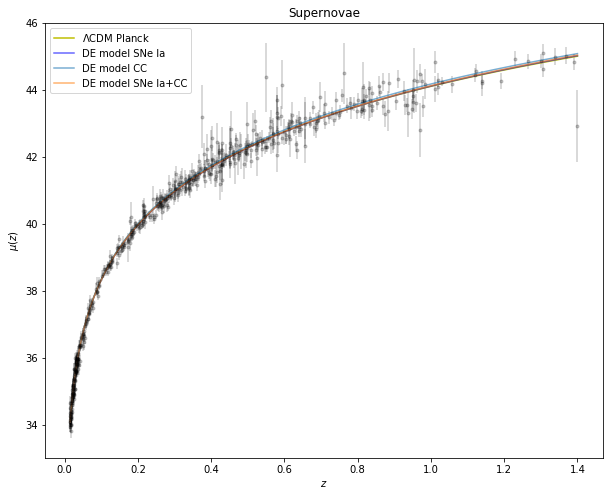

In [100]:
plt.figure(figsize=(10,8))
plt.errorbar(z_union2s, mu_z_union2s, yerr=sigma_mu_z_union2s, fmt=".k", capsize=0, alpha=0.2)
plt.plot(z0, model_LCDM_planck, label=r'$\Lambda$CDM Planck', color='y')
plt.plot(z0, model_f_sne_MCMC, label='DE model SNe Ia', color='b', alpha=0.6)
plt.plot(z0, model_f_H_MCMC, label='DE model CC', alpha=0.6)
plt.plot(z0, model_f_sneH_MCMC, label='DE model SNe Ia+CC', alpha=0.6)

plt.title('Supernovae')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu(z)$')
plt.legend()
plt.show()

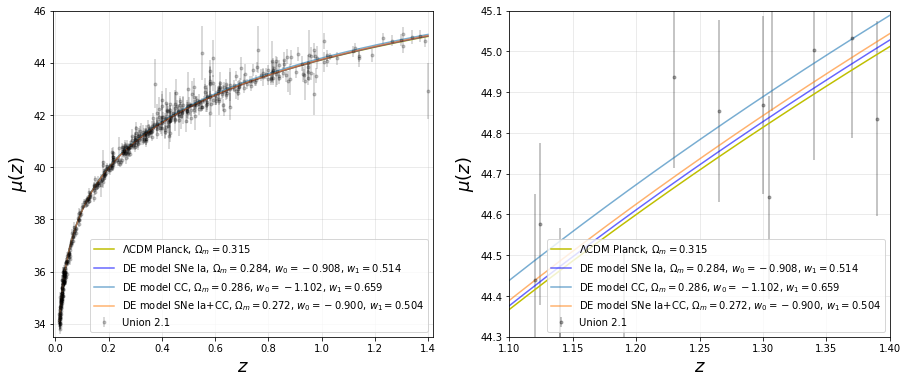

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))

ax1.errorbar(z_union2s, mu_z_union2s, yerr=sigma_mu_z_union2s, fmt=".k", capsize=0, alpha=0.2, label='Union 2.1')
ax1.plot(z0, model_LCDM_planck, label=r'$\Lambda$CDM Planck, $\Omega_m = 0.315$', color='y')
ax1.plot(z0, model_f_sne_MCMC, label='DE model SNe Ia, $\Omega_m = 0.284$, $w_0 = -0.908$, $w_1 = 0.514$', color='b', alpha=0.6)
ax1.plot(z0, model_f_H_MCMC, label='DE model CC, $\Omega_m = 0.286$, $w_0 = -1.102$, $w_1 = 0.659$', alpha=0.6)
ax1.plot(z0, model_f_sneH_MCMC, label='DE model SNe Ia+CC, $\Omega_m = 0.272$, $w_0 = -0.900$, $w_1 = 0.504$', alpha=0.6)
ax1.set_xlabel(r'$z$', fontsize=18)
ax1.set_ylabel(r'$\mu(z)$', fontsize=18)
ax1.legend(loc='lower right')
ax1.set_xlim([-0.01, 1.42])
ax1.set_ylim([33.5, 46])
ax1.grid(alpha=0.3)

ax2.errorbar(z_union2s, mu_z_union2s, yerr=sigma_mu_z_union2s, fmt=".k", capsize=0, alpha=0.3, label='Union 2.1')
ax2.plot(z0, model_LCDM_planck, label=r'$\Lambda$CDM Planck, $\Omega_m = 0.315$', color='y')
ax2.plot(z0, model_f_sne_MCMC, label='DE model SNe Ia, $\Omega_m = 0.284$, $w_0 = -0.908$, $w_1 = 0.514$', color='b', alpha=0.6)
ax2.plot(z0, model_f_H_MCMC, label='DE model CC, $\Omega_m = 0.286$, $w_0 = -1.102$, $w_1 = 0.659$', alpha=0.6)
ax2.plot(z0, model_f_sneH_MCMC, label='DE model SNe Ia+CC, $\Omega_m = 0.272$, $w_0 = -0.900$, $w_1 = 0.504$', alpha=0.6)
ax2.set_xlabel(r'$z$', fontsize=18)
ax2.set_ylabel(r'$\mu(z)$', fontsize=18)
ax2.legend(loc='lower right')
ax2.set_xlim([1.1, 1.4])
ax2.set_ylim([44.3, 45.1])
ax2.grid(alpha=0.3)


plt.savefig("mu.png", bbox_inches='tight', dpi=500)

plt.show()

Now lets plot the hubble parameter for our best fit results from the MCMC methods:

In [103]:
zH = np.linspace(0.07, 2.3,1000)

model_LCDM_planck_H = []
for i in zH:
    model_LCDM_planck_H.append(H(i, 0.315, 1, 1, f_L))
    
model_f_sne_MCMC_H = []
for i in zH:
    model_f_sne_MCMC_H.append(H(i, results_f_sne[2], results_f_sne[0], results_f_sne[1], f))
    
model_f_H_MCMC_H = []
for i in zH:
    model_f_H_MCMC_H.append(H(i, results_f_H[2], results_f_H[0], results_f_H[1], f))
    
model_f_sneH_MCMC_H = []
for i in zH:
    model_f_sneH_MCMC_H.append(H(i, results_f_sneH[2], results_f_sneH[0], results_f_sneH[1], f))

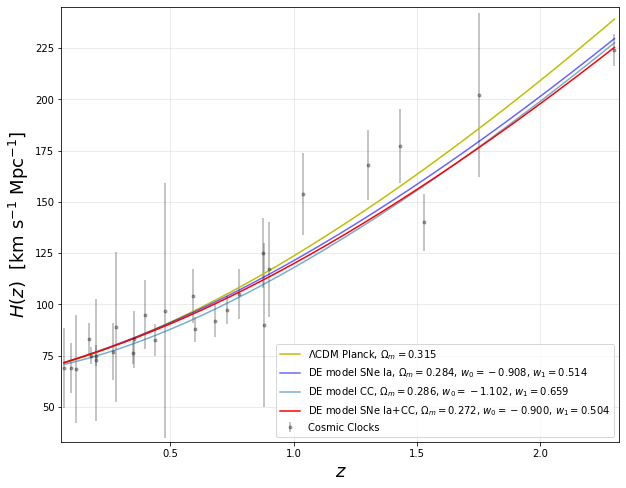

In [104]:
plt.figure(figsize=(10,8))
plt.errorbar(z_relojes, H_relojes, yerr=sigma_relojes, fmt=".k", capsize=0, alpha=0.3, label='Cosmic Clocks')
plt.plot(zH, model_LCDM_planck_H, label=r'$\Lambda$CDM Planck, $\Omega_m = 0.315$', color='y')
plt.plot(zH, model_f_sne_MCMC_H, label='DE model SNe Ia, $\Omega_m = 0.284$, $w_0 = -0.908$, $w_1 = 0.514$', color='b', alpha=0.6)
plt.plot(zH, model_f_H_MCMC_H, label='DE model CC, $\Omega_m = 0.286$, $w_0 = -1.102$, $w_1 = 0.659$', alpha=0.6)
plt.plot(zH, model_f_sneH_MCMC_H, label='DE model SNe Ia+CC, $\Omega_m = 0.272$, $w_0 = -0.900$, $w_1 = 0.504$', color='r', alpha=1)

plt.xlabel(r'$z$', fontsize=18)
plt.ylabel(r'$H(z)$  [km s$^{-1}$ Mpc$^{-1}$]', fontsize=18)
plt.xlim(0.06,2.32)
plt.ylim(33,245)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.savefig("H.png", bbox_inches='tight', dpi=500)
plt.show()

Lets combine the contour plots:

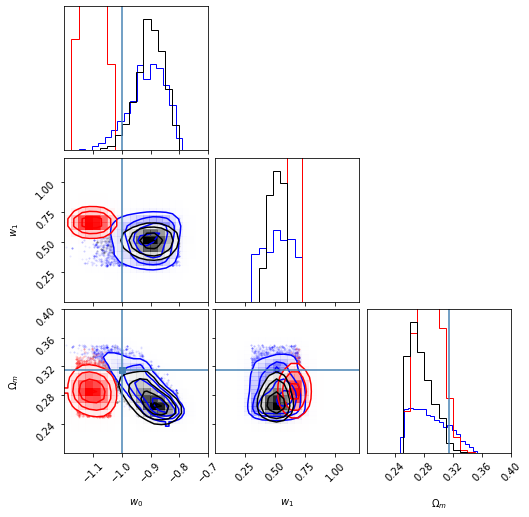

In [105]:
fig_f_sne_2 = corner.corner(flat_samples_f_sne, range=[(-1.15,-0.7),(0,1.2),(0.24,0.36)], smooth=0.9, color='b', labels=[r'$w_0$', r'$w_1$', r'$\Omega_m$']);
fig_f_H_2 = corner.corner(flat_samples_f_H, fig=fig_f_sne_2, range=[(-1.2,-0.7),(0,1.2),(0.2,0.4)], smooth=1, color='r', labels=[r'$w_0$', r'$w_1$', r'$\Omega_m$']);
fig_f_sneH_2 = corner.corner(flat_samples_f_sneH, fig=fig_f_H_2, range=[(-1.2,-0.7),(0,1.2),(0.2,0.4)], smooth=0.9, labels=[r'$w_0$', r'$w_1$', r'$\Omega_m$'], truths=[-1, 2, 0.315]);
fig_f_sneH_2.savefig("contoursall.png", bbox_inches='tight', dpi=500)

Lets plot $w(z)$ for the best fit parameters obtained:

C:\Users\aldox\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


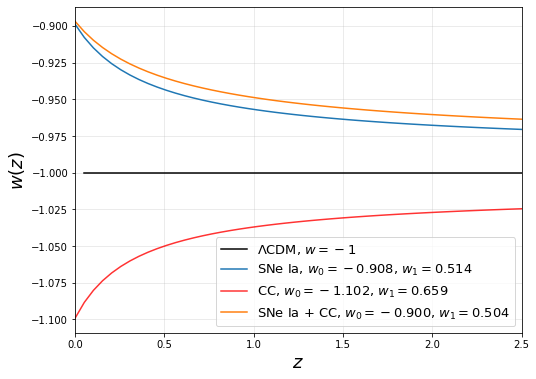

In [106]:
z_w = np.linspace(0,2.5)
plt.figure(figsize=(8,6))

plt.plot(z_w, w(z_w, -1, 1), label=r'$\Lambda$CDM, $w = -1$', color='k')
plt.plot(z_w, w(z_w, -0.899, 0.597), label='SNe Ia, $w_0 = -0.908$, $w_1 = 0.514$')
plt.plot(z_w, w(z_w, -1.099, 0.661), label='CC, $w_0 = -1.102$, $w_1 = 0.659$', color='r', alpha=0.8)
plt.plot(z_w, w(z_w, -0.897, 0.504), label='SNe Ia + CC, $w_0 = -0.900$, $w_1 = 0.504$')

plt.xlim(0, 2.5)
plt.legend(loc='lower right', fontsize=13)
plt.xlabel(r'$z$', fontsize=18)
plt.ylabel(r'$w(z)$', fontsize=18)
plt.grid(alpha=0.3)
plt.savefig("w_z.png", bbox_inches='tight', dpi=500)
plt.show()

Now lets plot the deceleration parameter:

$$ q(z)\equiv - \frac{\ddot{a} \, a}{\dot a^2} = - \frac{\ddot{a}}{a}\frac{1}{H^2} = \frac{1}{2} \frac{ \Omega_m + \Omega_X (1 + 3 w(z))  }{\Omega_m (1+z)^3 + \Omega_X f(z) } $$

In [107]:
def q(z, Om, w0, w1, w, fun):
    return 0.5*(Om + (1-Om)*(1+3*w(z, w0, w1)))/(Om*(1+z)**3 + (1-Om)*fun(z, w0, w1))

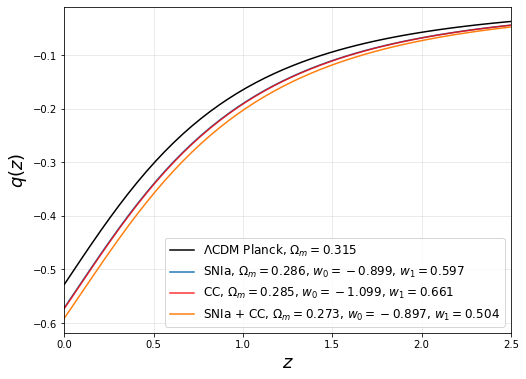

In [62]:
z_q = np.linspace(0,2.5)
plt.figure(figsize=(8,6))

plt.plot(z_q, q(z_q, 0.315, 1, 1, w_L, f_L), label=r'$\Lambda$CDM Planck, $\Omega_m = 0.315$', color='k')
plt.plot(z_q, q(z_q, 0.286, -0.899, 0.597, w_L, f_L), label='SNe Ia, $\Omega_m = 0.286$, $w_0 = -0.899$, $w_1 = 0.597$')
plt.plot(z_q, q(z_q, 0.285, -1.099, 0.661, w_L, f_L), label='CC, $\Omega_m = 0.285$, $w_0 = -1.099$, $w_1 = 0.661$', color='r', alpha=0.8)
plt.plot(z_q, q(z_q, 0.273, -0.897, 0.504, w_L, f_L), label='SNe Ia + CC, $\Omega_m = 0.273$, $w_0 = -0.897$, $w_1 = 0.504$')

plt.xlim(0, 2.5)
plt.legend(loc='lower right', fontsize=12)
plt.xlabel(r'$z$', fontsize=18)
plt.ylabel(r'$q(z)$', fontsize=18)
plt.grid(alpha=0.3)
plt.savefig("q_z.png", bbox_inches='tight', dpi=500)
plt.show()

Finally, lets plot the logarithm of the scale factor:
$$ \ln a(t) = \left\{ \left[1 + \frac{1+\gamma}{\ln w_1} H_0 \sqrt{\Omega_X} (t- t_0) \right]^{ \textstyle \frac{1}{\gamma + 1}}  - 1  \right\} \ln w_1 $$

or

$$a(t) = \frac{1}{w_1} \exp \left\{  \ln w_1 \left[1 + \frac{1+\gamma}{\ln w_1} H_0 \sqrt{\Omega_X} (t- t_0) \right]^{ \textstyle \frac{1}{\gamma + 1}} \right\}$$

In [108]:
def ln_a(t, w0, w1): #We will plot  ln(a) vs H_0 \sqrt{O_X} (t- t_0)
    return ( (1+ (1.5*np.log(w1)*(1+w0) + 1)*t/np.log(w1) )**(1/(1.5*np.log(w1)*(1+w0) + 1)) -1)*np.log(w1)

In [109]:
def a(t, w0, w1): #We will plot  ln(a) vs H_0 \sqrt{O_X} (t- t_0)
    return np.exp( np.log(w1)*(1+ (1.5*np.log(w1)*(1+w0) + 1)*t/np.log(w1) )**(1/(1.5*np.log(w1)*(1+w0)+1) ) )/w1

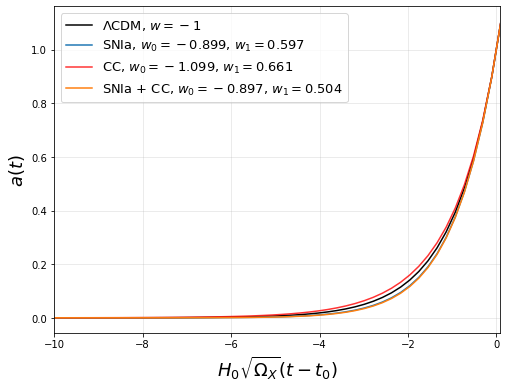

In [95]:
t = np.linspace(-10,0.1)

plt.figure(figsize=(8,6))

plt.plot(t, a(t, -1, 2), label=r'$\Lambda$CDM, $w = -1$', color='k')
plt.plot(t, a(t, -0.899, 0.597), label='SNe Ia, $w_0 = -0.899$, $w_1 = 0.597$')
plt.plot(t, a(t, -1.099, 0.661), label='CC, $w_0 = -1.099$, $w_1 = 0.661$', color='r', alpha=0.8)
plt.plot(t, a(t, -0.897, 0.504), label='SNe Ia + CC, $w_0 = -0.897$, $w_1 = 0.504$')

plt.xlim(-10, 0.09)
plt.legend(loc='upper left', fontsize=13)
plt.xlabel(r'$H_0 \sqrt{\Omega_X} (t- t_0)$', fontsize=18)
plt.ylabel(r'$a(t)$', fontsize=18)
plt.grid(alpha=0.3)
plt.savefig("a_t.png", bbox_inches='tight', dpi=500)
plt.show()

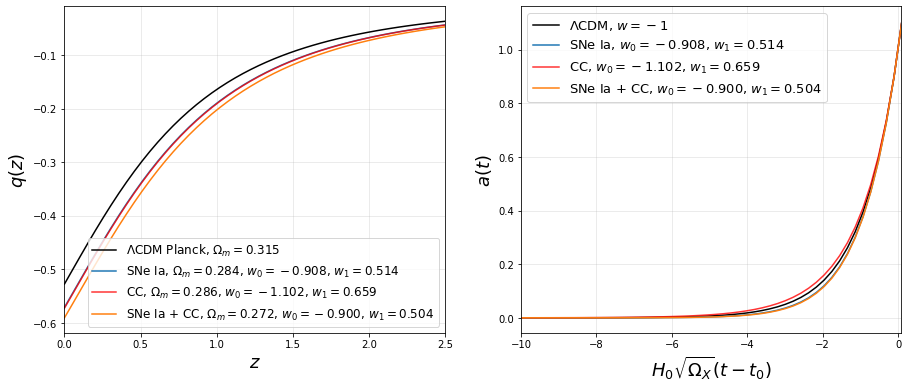

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))

z_q = np.linspace(0,2.5)
ax1.plot(z_q, q(z_q, 0.315, 1, 1, w_L, f_L), label=r'$\Lambda$CDM Planck, $\Omega_m = 0.315$', color='k')
ax1.plot(z_q, q(z_q, 0.286, -0.899, 0.597, w_L, f_L), label='SNe Ia, $\Omega_m = 0.284$, $w_0 = -0.908$, $w_1 = 0.514$')
ax1.plot(z_q, q(z_q, 0.285, -1.099, 0.661, w_L, f_L), label='CC, $\Omega_m = 0.286$, $w_0 = -1.102$, $w_1 = 0.659$', color='r', alpha=0.8)
ax1.plot(z_q, q(z_q, 0.273, -0.897, 0.504, w_L, f_L), label='SNe Ia + CC, $\Omega_m = 0.272$, $w_0 = -0.900$, $w_1 = 0.504$')
ax1.set_xlim(0, 2.5)
ax1.legend(loc='lower right', fontsize=12)
ax1.set_xlabel(r'$z$', fontsize=18)
ax1.set_ylabel(r'$q(z)$', fontsize=18)
ax1.grid(alpha=0.3)

t = np.linspace(-10,0.1)

ax2.plot(t, a(t, -1, 2), label=r'$\Lambda$CDM, $w = -1$', color='k')
ax2.plot(t, a(t, -0.899, 0.597), label='SNe Ia, $w_0 = -0.908$, $w_1 = 0.514$')
ax2.plot(t, a(t, -1.099, 0.661), label='CC, $w_0 = -1.102$, $w_1 = 0.659$', color='r', alpha=0.8)
ax2.plot(t, a(t, -0.897, 0.504), label='SNe Ia + CC, $w_0 = -0.900$, $w_1 = 0.504$')

ax2.set_xlim(-10, 0.09)
ax2.legend(loc='upper left', fontsize=13)
ax2.set_xlabel(r'$H_0 \sqrt{\Omega_X} (t- t_0)$', fontsize=18)
ax2.set_ylabel(r'$a(t)$', fontsize=18)
ax2.grid(alpha=0.3)

plt.savefig("q_y_a.png", bbox_inches='tight', dpi=500)

plt.show()